# ☘️ PLANT DISEASE CLASSIFICATION USING Custom CNN ☘️

# Description of the dataset 📝

# Our goal 🎯
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

##### Let's get started....

## Importing necessary libraries

Let's import required modules

We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# This is a Jupyter magic command to display plots inline
%matplotlib inline

# 🧭 Exploring the data 🧭

Loading the data 

In [2]:
DATA_DIR = "./new_data"
train_dir = DATA_DIR + "/train"
valid_dir = DATA_DIR + "/val"
test_dir = DATA_DIR + "/test"
diseases = os.listdir(train_dir)

In [3]:
# printing the disease names
print(diseases)

['Apple___alternaria_leaf_spot', 'Apple___black_rot', 'Apple___brown_spot', 'Apple___gray_spot', 'Apple___healthy', 'Apple___rust', 'Apple___scab', 'Bell_pepper___bacterial_spot', 'Bell_pepper___healthy', 'Blueberry___healthy', 'Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease', 'Cherry___healthy', 'Cherry___powdery_mildew', 'Chili__healthy', 'Chili__leaf curl', 'Chili__leaf spot', 'Chili__whitefly', 'Chili__yellowish', 'Coffee__cercospora_leaf_spot', 'Coffee___healthy', 'Coffee___red_spider_mite', 'Coffee___rust', 'Corn__gray_leaf_spot', 'Corn___common_rust', 'Corn___healthy', 'Corn___northern_leaf_blight', 'Cucumber__diseased', 'Cucumber__healthy', 'Gauva__diseased', 'Gauva__healthy', 'Grape___black_measles', 'Grape___black_rot', 'Grape___healthy', 'Grape___Leaf_blight', 'Jamun__diseased', 'Jamun__healthy', 'Lemon__diseased', 'Lemon__healthy', 'Mango__diseased', 'Mango__healthy', 'Orange___citrus_g

In [4]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 116


In [5]:
MODEL_NAME = "EfficientNetB3_FineTuned" 
NUM_CLASSES = 116
BATCH_SIZE = 16 # Increased to 32 for your RTX 4070. Lower to 16 if you get memory errors.
NUM_EPOCHS = 25 # Increased epochs for a more thorough training run
LEARNING_RATE = 0.001

CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [6]:
writer = SummaryWriter(f'runs/{MODEL_NAME}')

The above cell extract the number of unique plants and number of unique diseases

In [7]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('__')[0] not in plants:
        plants.append(plant.split('__')[0])
    if plant.split('__')[1] != 'healthy':
        NumberOfDiseases += 1

In [8]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Apple', 'Bell_pepper', 'Blueberry', 'Cassava', 'Cherry', 'Chili', 'Coffee', 'Corn', 'Cucumber', 'Gauva', 'Grape', 'Jamun', 'Lemon', 'Mango', 'Orange', 'Peach', 'Pepper_bell', 'Pomegranate', 'Potato', 'Raspberry', 'Rice', 'Rose', 'Soybean', 'Squash', 'Strawberry', 'Sugarcane', 'Sugercane', 'Tea', 'Tomato', 'Watermelon', 'Wheat']


In [9]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 31


In [10]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 104


In [11]:
CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [12]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Apple___alternaria_leaf_spot,222
Apple___black_rot,496
Apple___brown_spot,172
Apple___gray_spot,316
Apple___healthy,2056
...,...
Watermelon___mosaic_virus,332
Wheat__brown_rust,732
Wheat__healthy,980
Wheat__septoria,77


#### Visualizing the above information on a graph

Text(0.5, 1.0, 'Images per each class of plant disease')

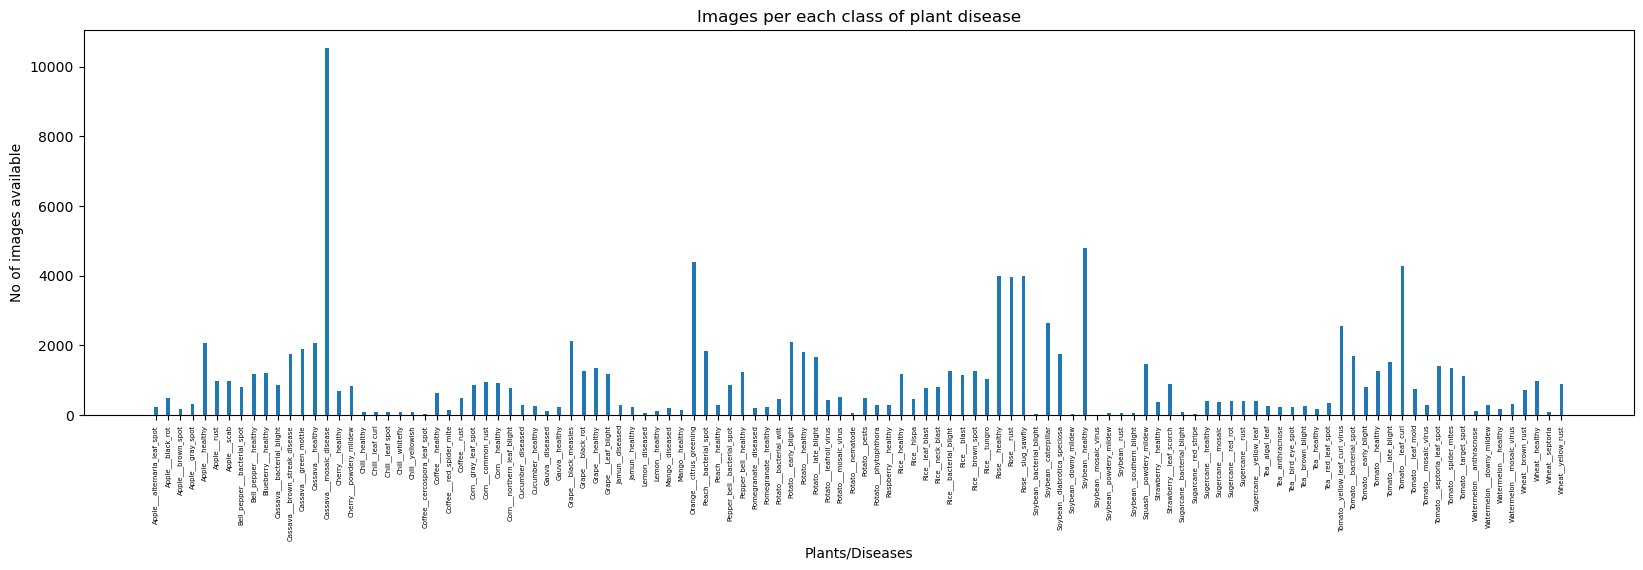

In [13]:
# plotting number of images available for each disease
index = [n for n in range(116)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [14]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 113804 images for training


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch Version: 2.8.0+cu128
CUDA Version: 12.8
GPU: NVIDIA GeForce GTX 1650


# 🍳 Data Preparation for training 🍳

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Add a transform for the test set
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Loading data...")
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=='train'), num_workers=4, pin_memory=True) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Dataset sizes: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}, Test={dataset_sizes['test']}")

Loading data...
Dataset sizes: Train=113803, Val=14162, Test=14342


In [17]:
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)
print("Class names saved to class_names.json")

Class names saved to class_names.json


*A "Good and Complex" Custom CNN Model Definition*

In [18]:
import platform
from torchvision import models
from torchsummary import summary

# --- Step 1: Load the pre-trained EfficientNet-B3 model ---
# We use the recommended modern weights API.
print("Loading pre-trained EfficientNet-B3 model...")
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)

# --- Step 2: Freeze all the parameters in the pre-trained model ---
# This is crucial for fine-tuning. We don't want to destroy the learned features.
for param in model.parameters():
    param.requires_grad = False

# --- Step 3: Replace the final classifier layer ---
# EfficientNet's classifier is a nn.Sequential containing a Dropout and a Linear layer.
# We need to find the number of input features to the final Linear layer.
num_ftrs = model.classifier[1].in_features

# Now, we replace the original classifier with a new one for our specific number of classes.
# It's good practice to include a Dropout layer for regularization.
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # Dropout with a probability of 0.3
    nn.Linear(num_ftrs, NUM_CLASSES)
)

# --- Step 4: Move the model to the correct device ---
model = model.to(device)

Loading pre-trained EfficientNet-B3 model...
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\swami/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:01<00:00, 29.3MB/s]


In [19]:
print(f"--- Model Summary for {MODEL_NAME} (before compilation) ---")
summary(model, input_size=(3, 224, 224))
print("-" * 70)

--- Model Summary for EfficientNetB3_FineTuned (before compilation) ---
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-

In [20]:
import platform

# --- Step 3: Conditionally compile the model ---
if int(torch.__version__.split('.')[0]) >= 2:
    # Check the operating system
    if platform.system() == "Windows":
        print("Windows OS detected. Skipping torch.compile() due to known issues with Triton dependency.")
    else:
        # On Linux or MacOS, compile the model for a performance boost.
        print("Linux or MacOS detected. Attempting to compile the model...")
        try:
            model = torch.compile(model)
            print("Model compiled successfully!")
        except Exception as e:
            print(f"Model compilation failed: {e}. Continuing without compilation.")
else:
    print("PyTorch version is less than 2.0. Skipping torch.compile.")

Windows OS detected. Skipping torch.compile() due to known issues with Triton dependency.


# 🏗️ Modelling 🏗️

It is advisable to use GPU instead of CPU when dealing with images dataset because CPUs are generalized for general purpose and GPUs are optimized for training deep learning models as they can process multiple computations simultaneously. They have a large number of cores, which allows for better computation of multiple parallel processes. Additionally, computations in deep learning need to handle huge amounts of data — this makes a GPU’s memory bandwidth most suitable.
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required

In [21]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# ✨ IMPORTANT CHANGE FOR FINE-TUNING ✨
# We must tell the optimizer to ONLY update the parameters of the new classifier.
# All other layers are frozen (requires_grad=False).
print("Setting up optimizer to train only the final classifier layer.")
optimizer = optim.AdamW(model.classifier.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# The scheduler works the same way, but it will operate on the smaller set of parameters.
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=NUM_EPOCHS, steps_per_epoch=len(dataloaders['train']))

Setting up optimizer to train only the final classifier layer.


In [22]:
LOAD_CHECKPOINT = True
CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
start_epoch = 0
if LOAD_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
    print(f"Checkpoint found at {CHECKPOINT_PATH}. Loading...")
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming training from Epoch {start_epoch}")
else:
    print("No checkpoint found. Starting training from scratch.")

No checkpoint found. Starting training from scratch.


In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, start_epoch=0, early_stopping_patience=5):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_epoch = start_epoch
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lrs': []}

    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda'))

    if LOAD_CHECKPOINT and os.path.exists(CHECKPOINT_PATH):
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        best_acc = checkpoint.get('accuracy', 0.0)
        print(f"Loaded best accuracy from previous run: {best_acc:.4f}")

    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}'); print('-' * 10)
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} phase"):
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with torch.set_grad_enabled(phase == 'train'):
                    with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                        scaler.step(optimizer)
                        scaler.update()
                        scheduler.step()
                        history['lrs'].append(optimizer.param_groups[0]['lr'])
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Log to history and TensorBoard
            if phase == 'train':
                history['train_loss'].append(epoch_loss); history['train_acc'].append(epoch_acc.item())
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
            else:
                history['val_loss'].append(epoch_loss); history['val_acc'].append(epoch_acc.item())
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc, best_epoch, epochs_no_improve = epoch_acc, epoch, 0
                    best_model_wts = model.state_dict()
                    save_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
                    torch.save({'epoch': epoch, 'model_state_dict': best_model_wts, 'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler_state_dict': scheduler.state_dict(), 'loss': epoch_loss, 'accuracy': best_acc}, save_path)
                    print(f"New best model saved with accuracy: {best_acc:.4f}")
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= early_stopping_patience:
                        print(f"Early stopping triggered. No improvement in {early_stopping_patience} validation epochs.")
                        model.load_state_dict(best_model_wts)
                        writer.close()
                        return model, history
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f} at epoch {best_epoch+1}')
    last_epoch_path = os.path.join(CHECKPOINT_DIR, 'last_model.pth')
    torch.save({
        'epoch': num_epochs - 1, # or epoch if early stopping triggered
        'model_state_dict': model.state_dict(), # The state at the very end
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, last_epoch_path)
    print(f"Last checkpoint saved to {last_epoch_path}")

    # Load the best model weights for returning from the function
    model.load_state_dict(best_model_wts)
    writer.close()
    return model, history

In [26]:
model, history = train_model(model, criterion, optimizer, scheduler, 
                             num_epochs=NUM_EPOCHS, 
                             start_epoch=start_epoch,
                             early_stopping_patience=5)

Epoch 1/25
----------


train phase:   0%|          | 0/7113 [00:00<?, ?it/s]c:\Users\swami\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
train phase: 100%|██████████| 7113/7113 [18:16<00:00,  6.49it/s]


train Loss: nan Acc: 0.0020


val phase: 100%|██████████| 886/886 [02:46<00:00,  5.31it/s]


val Loss: nan Acc: 0.0019
New best model saved with accuracy: 0.0019

Epoch 2/25
----------


train phase: 100%|██████████| 7113/7113 [17:58<00:00,  6.60it/s]


train Loss: nan Acc: 0.0020


val phase: 100%|██████████| 886/886 [02:43<00:00,  5.42it/s]


val Loss: nan Acc: 0.0019

Epoch 3/25
----------


train phase: 100%|██████████| 7113/7113 [17:58<00:00,  6.59it/s]


train Loss: nan Acc: 0.0020


val phase: 100%|██████████| 886/886 [02:43<00:00,  5.41it/s]


val Loss: nan Acc: 0.0019

Epoch 4/25
----------


train phase: 100%|██████████| 7113/7113 [17:58<00:00,  6.60it/s]


train Loss: nan Acc: 0.0020


val phase: 100%|██████████| 886/886 [02:43<00:00,  5.42it/s]


val Loss: nan Acc: 0.0019

Epoch 5/25
----------


train phase: 100%|██████████| 7113/7113 [17:58<00:00,  6.60it/s]


train Loss: nan Acc: 0.0020


val phase: 100%|██████████| 886/886 [02:43<00:00,  5.42it/s]


val Loss: nan Acc: 0.0019

Epoch 6/25
----------


train phase: 100%|██████████| 7113/7113 [17:58<00:00,  6.60it/s]


train Loss: nan Acc: 0.0020


val phase: 100%|██████████| 886/886 [02:43<00:00,  5.43it/s]

val Loss: nan Acc: 0.0019
Early stopping triggered. No improvement in 5 validation epochs.


In [27]:


# --- UNIFIED PLOTTING FUNCTION ---
def plot_training_history(history, model_name):
    """
    Plots training & validation accuracy/loss. Annotates best val accuracy.
    """
    train_acc = history['train_acc']
    val_acc = history['val_acc']
    train_loss = history['train_loss']
    val_loss = history['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(f'Training History for {model_name}', fontsize=16)

    ax1.plot(train_acc, label='Train Acc', marker='o')
    ax1.plot(val_acc, label='Val Acc', marker='o')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, alpha=0.3)

    if val_acc:
        best_epoch = int(np.argmax(val_acc))
        best_val_acc = val_acc[best_epoch]
        ax1.axvline(best_epoch, color='r', linestyle='--', linewidth=1)
        ax1.annotate(f'Best: {best_val_acc:.4f}\nEp {best_epoch+1}',
                     xy=(best_epoch, best_val_acc),
                     xytext=(best_epoch, max(0, best_val_acc - 0.1)),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     ha='center', fontsize=10)
    ax1.legend()

    ax2.plot(train_loss, label='Train Loss', marker='o')
    ax2.plot(val_loss, label='Val Loss', marker='o')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()


def plot_learning_rate_schedule(history):
    lrs = history.get('lrs', [])
    if len(lrs) > 0:
        plt.figure(figsize=(12,4))
        plt.plot(lrs)
        plt.title('Learning Rate (per batch)')
        plt.xlabel('Batch # (cumulative)')
        plt.ylabel('LR')
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print('No LR data to plot.')

# --- Evaluation helpers ---
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Eval'):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds


def plot_confusion_matrix(labels, preds, class_names, normalize=True, max_classes_display=50):
    cm = confusion_matrix(labels, preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    # If too many classes, show a subset heatmap legend only
    if len(class_names) > max_classes_display:
        print(f"Too many classes ({len(class_names)}). Showing aggregated stats.")
        avg_diag = np.nanmean(np.diag(cm))
        print(f"Mean per-class accuracy: {avg_diag:.4f}")
        return
    plt.figure(figsize=(min(1+0.3*len(class_names), 25), min(1+0.3*len(class_names), 25)))
    sns.heatmap(cm, cmap='viridis', xticklabels=class_names, yticklabels=class_names, fmt='.2f' if normalize else 'd')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()


def show_misclassified(model, dataloader, class_names, device, n=12):
    model.eval()
    images = []
    labels_true = []
    labels_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            mismatch = preds != labels.to(device)
            if mismatch.any():
                for i in torch.where(mismatch)[0]:
                    images.append(inputs[i].cpu())
                    labels_true.append(labels[i].item())
                    labels_pred.append(preds[i].item())
                    if len(images) >= n:
                        break
            if len(images) >= n:
                break
    if len(images) == 0:
        print('No misclassifications found in this subset.')
        return
    # Denormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    cols = 4
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=(cols*4, rows*4))
    for idx, img in enumerate(images):
        img_dn = img*std + mean
        img_np = np.clip(img_dn.permute(1,2,0).numpy(), 0, 1)
        ax = plt.subplot(rows, cols, idx+1)
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"T: {class_names[labels_true[idx]][:15]}\nP: {class_names[labels_pred[idx]][:15]}", fontsize=9)
    plt.suptitle('Sample Misclassified Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Grad-CAM (lightweight) ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        selected = output[0, class_idx]
        selected.backward(retain_graph=True)
        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min)/(cam_max - cam_min + 1e-8)
        return cam[0,0].cpu().numpy()


def visualize_gradcam(model, dataloader, class_names, device, n=3):
    # Pick the last residual layer for Grad-CAM
    target_layer = model.layer4[-1].bn2
    gradcam = GradCAM(model, target_layer)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    shown = 0
    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            if shown >= n:
                return
            inp = inputs[i:i+1].to(device)
            cam = gradcam.generate(inp)
            img = (inputs[i]*std + mean).permute(1,2,0).numpy()
            img = np.clip(img, 0, 1)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.imshow(cam, cmap='jet', alpha=0.4)
            pred_class = class_names[model(inp).argmax(1).item()]
            plt.title(f"True: {class_names[labels[i]]}\nPred: {pred_class}")
            plt.axis('off')
            plt.show()
            shown += 1

print("Visualization & evaluation helpers ready.")

Visualization & evaluation helpers ready.



--- Generating Training Plots ---


C:\Users\swami\AppData\Local\Temp\ipykernel_4104\3739050811.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


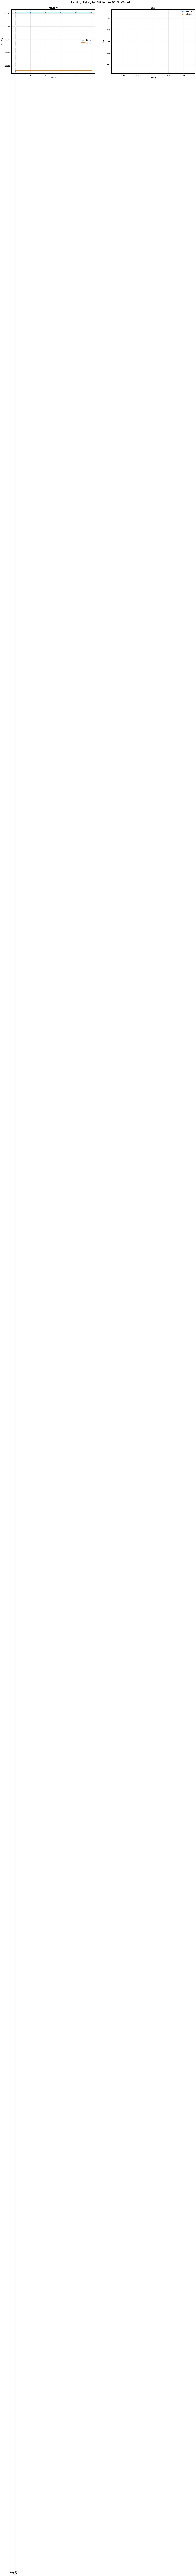

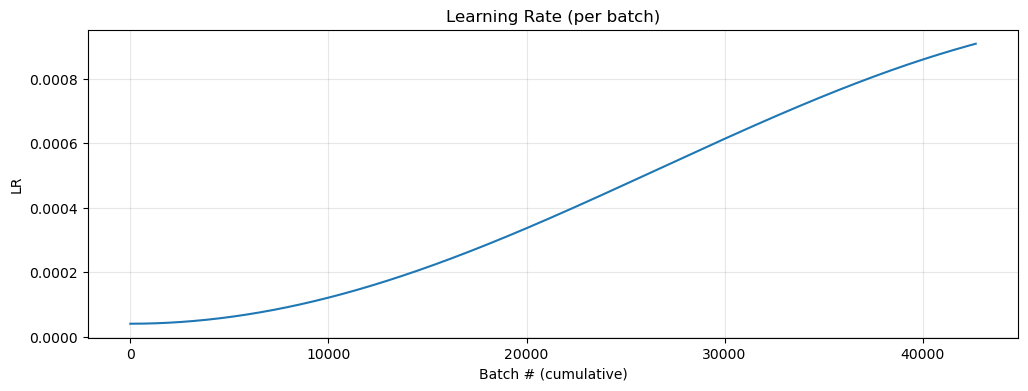

In [28]:
print("\n--- Generating Training Plots ---")
plot_training_history(history, MODEL_NAME)
plot_learning_rate_schedule(history)

In [29]:
print("\n--- Evaluating on Test Set ---")
# IMPORTANT: Load the BEST model from checkpoint for final evaluation
print("Loading best model for final evaluation...")
final_model = EfficientNet(ResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES)
if int(torch.__version__.split('.')[0]) >= 2:
    final_model = torch.compile(final_model) # Compile the evaluation model too
final_model.to(device)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
final_model.load_state_dict(checkpoint['model_state_dict'])

# Get predictions and labels
test_labels, test_preds = evaluate_model(final_model, dataloaders['test'], class_names, device)

# Print Classification Report
print("\n--- Classification Report ---")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# Plot Confusion Matrix
print("\n--- Confusion Matrix ---")
plot_confusion_matrix(test_labels, test_preds, class_names)

# Show some misclassified images
print("\n--- Sample Misclassified Images ---")
show_misclassified(final_model, dataloaders['test'], class_names, device)

# Show Grad-CAM visualizations
print("\n--- Grad-CAM Visualizations ---")
# For Grad-CAM, it's often better to target the final conv layer before the BN
target_layer = final_model.layer4[-1].conv2 
visualize_gradcam(final_model, dataloaders['test'], class_names, device, target_layer=target_layer)


--- Evaluating on Test Set ---
Loading best model for final evaluation...


NameError: name 'EfficientNet' is not defined